<a href="https://colab.research.google.com/github/kaarthikalagappan/ai_course_projects/blob/master/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG16 (Adapted from Dr. Wocjan's notebook)

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-19 19:36:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   149MB/s    in 0.4s    

2020-04-19 19:36:52 (149 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with ResNet50 convolution base and custom densely connected layers

### Load the convolutional base

In [7]:
from keras.applications import ResNet50V2

conv_base = ResNet50V2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

94674944/94668760 [==============================] - 3s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 36,672,513
Trainable params: 13,107,713
Non-trainable params: 23,564,800
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 31s 307ms/step - loss: 0.5198 - acc: 0.7550 - val_loss: 0.0756 - val_acc: 0.9560
Epoch 2/30
100/100 [==============================] - 20s 205ms/step - loss: 0.3584 - acc: 0.8445 - val_loss: 0.0998 - val_acc: 0.9530
Epoch 3/30
100/100 [==============================] - 20s 204ms/step - loss: 0.3495 - acc: 0.8585 - val_loss: 0.0285 - val_acc: 0.9650
Epoch 4/30
100/100 [==============================] - 20s 203ms/step - loss: 0.2932 - acc: 0.8750 - val_loss: 0.0489 - val_acc: 0.9650
Epoch 5/30
100/100 [==============================] - 20s 203ms/step - loss: 0.3275 - acc: 0.8555 - val_loss: 1.6726e-04 - val_acc: 0.9520
Epoch 6/30
100/100 [==============================] - 20s 203ms/step - loss: 0.3208 - acc: 0.8625 - val_loss: 0.0037 - val_acc: 0.9630
Epoch 7/30
100/100 [==============================] - 21s 205ms/step - loss: 0.2891 - acc: 0.8810 - va

## Display curves of loss and accuracy during training

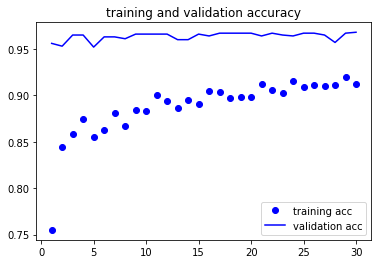

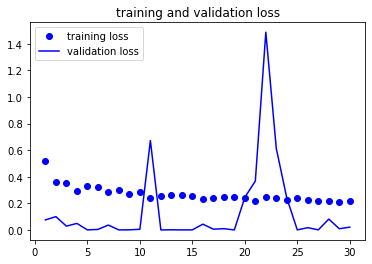

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [13]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
#   print(layer.name)
  if layer.name == 'conv4_block4_preact_bn':
    print("yes")
    set_trainable = True
  elif layer.name == 'conv4_block5_preact_bn':
    print("no")
    set_trainable = False
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

yes
no


In [14]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=75,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=25)

Epoch 1/100
75/75 [==============================] - 22s 287ms/step - loss: 0.2317 - acc: 0.9113 - val_loss: 0.0036 - val_acc: 0.9480
Epoch 2/100
75/75 [==============================] - 15s 200ms/step - loss: 0.2548 - acc: 0.8960 - val_loss: 0.4022 - val_acc: 0.9540
Epoch 3/100
75/75 [==============================] - 16s 211ms/step - loss: 0.1895 - acc: 0.9200 - val_loss: 0.0012 - val_acc: 0.9260
Epoch 4/100
75/75 [==============================] - 16s 209ms/step - loss: 0.1973 - acc: 0.9240 - val_loss: 0.0759 - val_acc: 0.9300
Epoch 5/100
75/75 [==============================] - 16s 211ms/step - loss: 0.2190 - acc: 0.9253 - val_loss: 0.0513 - val_acc: 0.9400
Epoch 6/100
75/75 [==============================] - 16s 210ms/step - loss: 0.1942 - acc: 0.9213 - val_loss: 0.0816 - val_acc: 0.9400
Epoch 7/100
75/75 [==============================] - 16s 211ms/step - loss: 0.1953 - acc: 0.9227 - val_loss: 0.0615 - val_acc: 0.9360
Epoch 8/100
75/75 [==============================] - 16s 209ms

## Display learning curves during fine-tuning

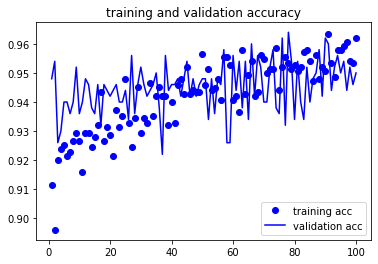

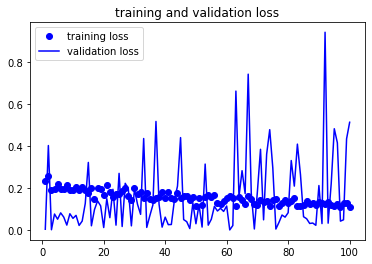

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

To achieve this level of accuracy rate, I had to experiment with what sets of layers unfrozen produces the best set of accuracy rates while not overfitting too much. The number of layers in this classifier turned out to be the best model I was able to for this training data after a few experimentation.



## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [17]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.23170635104179382
Validation accuracy: 0.9480000138282776


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
# Commented out since it was breaking (TypeError: NetworkError when attempting to fetch resource.)
# from google.colab import files

# with open(model_fname, 'r') as f:
#   files.download(model_fname)